In [39]:
from datasets import load_dataset
import pandas as pd
from matplotlib import pyplot as plt

import torch
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import Dataset

# 1. Understanding the data

In [47]:
# Specify the full paths to your JSON files
data_files = {'train': 'dataset/train.json', 
              'test': 'dataset/test.json', 
              'validation': 'dataset/validate.json'}

# Load the dataset
dataset = load_dataset("json", data_files=data_files)

# Get split lengths
split_lengths = [len(dataset[split]) for split in dataset]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset['train'].column_names}")
print("\nPlain_text:")
print(dataset["test"][0]["plain_text"])
print("\nSummary:")
print(dataset["test"][0]["summary"])

Split lengths: [720, 90, 90]
Features: ['plain_text', 'summary']

Plain_text:
What Personal Data Does Bandcamp Collect? Third parties may also collect information about your website activity over time and on other websites or mobile applications. Bandcamp cookies do not collect Personal Data, and we do not combine the general information collected through cookies with other Personal Data to tell us who you are or what your screen name or email address is. We use Google Analytics to collect and process analytical data about users of Bandcamp’s website. For Which Purposes Will Bandcamp Use Your Personal Data? We may receive Personal Data relating to you from:  You directly when you provide us with information about you; Your use of Bandcamp’s Service; Third parties that provide us with information about you. if Bandcamp, or substantially all of its assets were acquired, or in the unlikely event that Bandcamp goes out of business or enters bankruptcy, customer information would be one of 

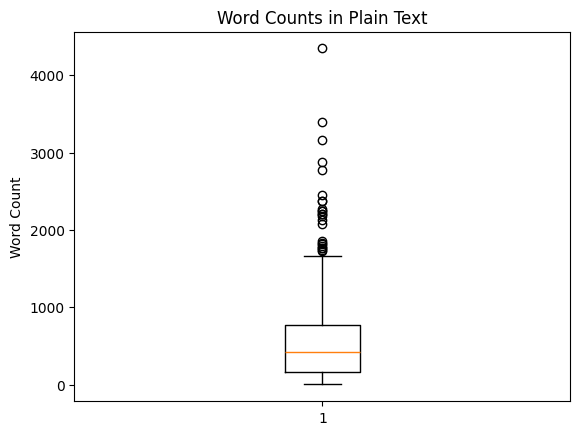

In [48]:
# Convert the dataset to Pandas DataFrames
df_train = pd.DataFrame(dataset["train"])

# Calculate word counts for plain_text and summary columns
df_train["WordsCount"] = df_train["plain_text"].str.split().apply(len)
df_train["SummaryCount"] = df_train["summary"].str.split().apply(len)

# Create a boxplot without outliers
plt.boxplot(df_train["WordsCount"])
plt.title("Word Counts in Plain Text")
plt.ylabel("Word Count")
plt.show()

In [49]:
df_train.boxplot("SummaryCount", grid=False, showfliers=False)

<Axes: >

# 2. Fine-Tuning

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, tokenizer, df, max_length=512, max_target_length=128):
        self.input_ids = []
        self.attention_mask = []
        self.labels = []

        for _, row in df.iterrows():
            inputs = tokenizer.encode_plus(row['plain_text'], max_length=max_length, return_tensors='pt', truncation=True)
            labels = tokenizer.encode_plus(row['summary'], max_length=max_target_length, return_tensors='pt', truncation=True)

            self.input_ids.append(inputs.input_ids.flatten())
            self.attention_mask.append(inputs.attention_mask.flatten())
            self.labels.append(labels.input_ids.flatten())

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {'input_ids': self.input_ids[idx], 
                'attention_mask': self.attention_mask[idx], 
                'labels': self.labels[idx]}

try:
    # Load the fine-tuning dataset
    df = pd.read_json('Modeling\models\dataset\dataset.json', lines=True)

    # Split the data into training and validation sets
    train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

    # Load BART pre-trained model and tokenizer
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
    model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

    # Create datasets
    train_dataset = CustomDataset(tokenizer, train_df)
    val_dataset = CustomDataset(tokenizer, val_df)

    # Define training configurations
    training_args = TrainingArguments(
        output_dir='./results',
        overwrite_output_dir=True,
        num_train_epochs=3,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        logging_steps=100,
        save_steps=500,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        evaluation_strategy="epoch"
    )

    # Define data collator
    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

    # Define the Trainer object
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator
    )

    # Start training using the Trainer instance
    trainer.train()

except Exception as e:
    print(f"An error occurred: {e}")

# 3. Predictions

In [ ]:
def generate_summary(text):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Example usage
new_text = "Your new text that you want to summarize."
print(generate_summary(new_text))

# 4. Evaluation

In [ ]:
evaluation_results = trainer.evaluate()
print(evaluation_results)